In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.distributions import Normal
import random
import numpy as np


## 1.ÂÆö‰πâÁÆóÊ≥ï
### 1.1 Âª∫Á´ãQÁΩëÁªúÂíåÁ≠ñÁï•ÁΩëÁªú

In [2]:
class ValueNet(nn.Module):
    def __init__(self, n_states, hidden_dim, init_w=3e-3):
        super(ValueNet, self).__init__()
        '''ÂÆö‰πâÂÄºÁΩëÁªú
        '''
        self.linear1 = nn.Linear(n_states, hidden_dim) # ËæìÂÖ•Â±Ç
        self.linear2 = nn.Linear(hidden_dim, hidden_dim) # ÈöêËóèÂ±Ç
        self.linear3 = nn.Linear(hidden_dim, 1)

        self.linear3.weight.data.uniform_(-init_w, init_w) # ÂàùÂßãÂåñÊùÉÈáç
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
        
        
class SoftQNet(nn.Module):
    def __init__(self, n_states, n_actions, hidden_dim, init_w=3e-3):
        super(SoftQNet, self).__init__()
        '''ÂÆö‰πâQÁΩëÁªúÔºån_states, n_actions, hidden_dim, init_wÂàÜÂà´‰∏∫Áä∂ÊÄÅÁª¥Â∫¶„ÄÅÂä®‰ΩúÁª¥Â∫¶ÈöêËóèÂ±ÇÁª¥Â∫¶ÂíåÂàùÂßãÂåñÊùÉÈáç
        '''
        self.linear1 = nn.Linear(n_states + n_actions, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
        
        
class PolicyNet(nn.Module):
    def __init__(self, n_states, n_actions, hidden_dim, init_w=3e-3, log_std_min=-20, log_std_max=2):
        super(PolicyNet, self).__init__()
        '''ÂÆö‰πâÁ≠ñÁï•ÁΩëÁªúÔºån_states, n_actions, hidden_dim, init_wÂàÜÂà´‰∏∫Áä∂ÊÄÅÁª¥Â∫¶„ÄÅÂä®‰ΩúÁª¥Â∫¶ÈöêËóèÂ±ÇÁª¥Â∫¶ÂíåÂàùÂßãÂåñÊùÉÈáç
        log_std_minÂíålog_std_max‰∏∫Ê†áÂáÜÂ∑ÆÂØπÊï∞ÁöÑÊúÄÂ§ßÂÄºÂíåÊúÄÂ∞èÂÄº
        '''
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.linear1 = nn.Linear(n_states, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        
        self.mean_linear = nn.Linear(hidden_dim, n_actions)
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)
        
        self.log_std_linear = nn.Linear(hidden_dim, n_actions)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        
        mean    = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        return mean, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        ## ËÆ°ÁÆóÂä®‰Ωú
        normal = Normal(mean, std)
        z = normal.sample()
        action = torch.tanh(z)
        ## ËÆ°ÁÆóÂä®‰ΩúÊ¶ÇÁéá
        log_prob = normal.log_prob(z) - torch.log(1 - action.pow(2) + epsilon)
        log_prob = log_prob.sum(-1, keepdim=True)
        
        return action, log_prob, z, mean, log_std
        
    
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(mean, std)
        z      = normal.sample()
        action = torch.tanh(z)
        
        action  = action.detach().cpu().numpy()
        return action[0]

### 1.2 ÂÆö‰πâÁªèÈ™åÂõûÊîæÊ±†

In [3]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity # ÁªèÈ™åÂõûÊîæÁöÑÂÆπÈáè
        self.buffer = [] # ÁºìÂÜ≤Âå∫
        self.position = 0 
    
    def push(self, state, action, reward, next_state, done):
        ''' ÁºìÂÜ≤Âå∫ÊòØ‰∏Ä‰∏™ÈòüÂàóÔºåÂÆπÈáèË∂ÖÂá∫Êó∂ÂéªÊéâÂºÄÂßãÂ≠òÂÖ•ÁöÑËΩ¨Áßª(transition)
        '''
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity 
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size) # ÈöèÊú∫ÈááÂá∫Â∞èÊâπÈáèËΩ¨Áßª
        state, action, reward, next_state, done =  zip(*batch) # Ëß£ÂéãÊàêÁä∂ÊÄÅÔºåÂä®‰ΩúÁ≠â
        return state, action, reward, next_state, done
    
    def __len__(self):
        ''' ËøîÂõûÂΩìÂâçÂ≠òÂÇ®ÁöÑÈáè
        '''
        return len(self.buffer)

### 1.3 SACÁÆóÊ≥ï

In [4]:
class SAC:
    def __init__(self,cfg) -> None:
        self.n_states = cfg.n_states
        self.n_actions = cfg.n_actions
        self.batch_size  = cfg.batch_size 
        self.memory = ReplayBuffer(cfg.capacity)
        self.device = cfg.device
        self.action_space = cfg.action_space
        self.value_net  = ValueNet(self.n_states, cfg.hidden_dim).to(self.device)
        self.target_value_net = ValueNet(self.n_states, cfg.hidden_dim).to(self.device)
        self.soft_q_net = SoftQNet(self.n_states, self.n_actions, cfg.hidden_dim).to(self.device)
        self.policy_net = PolicyNet(self.n_states, self.n_actions, cfg.hidden_dim).to(self.device)  
        self.value_optimizer  = Adam(self.value_net.parameters(), lr=cfg.value_lr)
        self.soft_q_optimizer = Adam(self.soft_q_net.parameters(), lr=cfg.soft_q_lr)
        self.policy_optimizer = Adam(self.policy_net.parameters(), lr=cfg.policy_lr)  
        for target_param, param in zip(self.target_value_net.parameters(), self.value_net.parameters()):
            target_param.data.copy_(param.data)
        self.value_criterion  = nn.MSELoss()
        self.soft_q_criterion = nn.MSELoss()
    def update(self, gamma=0.99,mean_lambda=1e-3,
        std_lambda=1e-3,
        z_lambda=0.0,
        soft_tau=1e-2,
        ):
        if len(self.memory) < self.batch_size: # ÂΩìÁªèÈ™åÂõûÊîæ‰∏≠‰∏çÊª°Ë∂≥‰∏Ä‰∏™ÊâπÈáèÊó∂Ôºå‰∏çÊõ¥Êñ∞Á≠ñÁï•
            return 
        state, action, reward, next_state, done = self.memory.sample(self.batch_size) # ‰ªéÁªèÈ™åÂõûÊîæ‰∏≠ÈöèÊú∫ÈááÊ†∑‰∏Ä‰∏™ÊâπÈáèÁöÑËΩ¨Áßª(transition)
        # Â∞ÜÊï∞ÊçÆËΩ¨Êç¢‰∏∫tensor
        state      = torch.FloatTensor(state).to(self.device)
        next_state = torch.FloatTensor(next_state).to(self.device)
        action     = torch.FloatTensor(action).to(self.device)
        reward     = torch.FloatTensor(reward).unsqueeze(1).to(self.device)
        done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(self.device)
        
        expected_q_value = self.soft_q_net(state, action) #ËÆ°ÁÆótÊó∂ÂàªÁöÑÁä∂ÊÄÅ-Âä®‰ΩúQÂÄº
        expected_value   = self.value_net(state) #ËÆ°ÁÆótÊó∂ÂàªÁöÑÁä∂ÊÄÅÂÄº
        new_action, log_prob, z, mean, log_std = self.policy_net.evaluate(state) #ËÆ°ÁÆótÊó∂ÂàªÁöÑÂä®‰Ωú„ÄÅÂä®‰Ωú‰ººÁÑ∂Ê¶ÇÁéá„ÄÅÊ≠£ÊÄÅÂàÜÂ∏ÉÊäΩÊ†∑„ÄÅÂàÜÂ∏ÉÂùáÂÄºÂíåÊ†áÂáÜÂ∑Æ


        target_value = self.target_value_net(next_state) #ËÆ°ÁÆót+1Êó∂ÂàªÁöÑÁä∂ÊÄÅÂÄº
        next_q_value = reward + (1 - done) * gamma * target_value # Êó∂Â∫èÂ∑ÆÂàÜËÆ°ÁÆót+1Êó∂ÂàªÁöÑQÂÄº
        # JQ = ùîº(st,at)~D[0.5(Q1(st,at) - r(st,at) - Œ≥(ùîºst+1~p[V(st+1)]))^2]
        q_value_loss = self.soft_q_criterion(expected_q_value, next_q_value.detach()) #ËÆ°ÁÆóqÁΩëË∑ØÁöÑÊçüÂ§±ÂáΩÊï∞

        expected_new_q_value = self.soft_q_net(state, new_action) #ËÆ°ÁÆótÊó∂ÂàªÂä®‰ΩúÂØπÂ∫îÁöÑqÂÄº
        next_value = expected_new_q_value - log_prob # ËÆ°ÁÆótÊó∂ÂàªÁöÑvÂÄº
        value_loss = self.value_criterion(expected_value, next_value.detach()) #ËÆ°ÁÆóÂÄºÁΩëÁªúÊçüÂ§±ÂáΩÊï∞
        
        ## ËÆ°ÁÆóÁ≠ñÁï•ÊçüÂ§±
        log_prob_target = expected_new_q_value - expected_value 
        # JœÄ = ùîºst‚àºD,Œµt‚àºN[Œ± * logœÄ(f(Œµt;st)|st) ‚àí Q(st,f(Œµt;st))]
        policy_loss = (log_prob * (log_prob - log_prob_target).detach()).mean()

        ## ËÆ°ÁÆóreparameterizationÂèÇÊï∞ÊçüÂ§±
        mean_loss = mean_lambda * mean.pow(2).mean()
        std_loss  = std_lambda  * log_std.pow(2).mean()
        z_loss    = z_lambda    * z.pow(2).sum(1).mean()

        policy_loss += mean_loss + std_loss + z_loss

        self.soft_q_optimizer.zero_grad()
        q_value_loss.backward()
        self.soft_q_optimizer.step()

        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()

        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()
        ## Êõ¥Êñ∞ÁõÆÊ†áÂÄºÁΩëÁªúÂèÇÊï∞
        for target_param, param in zip(self.target_value_net.parameters(), self.value_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )


## 2.Ê®°ÂûãËÆ≠ÁªÉ‰∏éÊµãËØï

In [5]:
def train(cfg, env, agent):
    print("ÂºÄÂßãËÆ≠ÁªÉÔºÅ")
    rewards = [] # ËÆ∞ÂΩïÊâÄÊúâÂõûÂêàÁöÑÂ•ñÂä±
    for i_ep in range(cfg.train_eps):
        state = env.reset() # ÈáçÁΩÆÁéØÂ¢ÉÔºåËøîÂõûÂàùÂßãÁä∂ÊÄÅ
        ep_reward = 0 # ËÆ∞ÂΩï‰∏ÄÂõûÂêàÂÜÖÁöÑÂ•ñÂä±
        for i_step in range(cfg.max_steps):
            action = agent.policy_net.get_action(state)  # ÊäΩÊ†∑Âä®‰Ωú
            next_state, reward, terminated, info = env.step(action)  # Êõ¥Êñ∞ÁéØÂ¢ÉÔºåËøîÂõûtransitions
            agent.memory.push(state, action, reward,next_state, terminated)  # ‰øùÂ≠òtransition
            agent.update()  # Êõ¥Êñ∞Êô∫ËÉΩ‰Ωì
            state = next_state  # Êõ¥Êñ∞‰∏ã‰∏Ä‰∏™Áä∂ÊÄÅ
            ep_reward += reward  # Á¥ØÂä†Â•ñÂä±
            if terminated:
                break
        if (i_ep+1)%10 == 0:
            print(f"ÂõûÂêàÔºö{i_ep+1}/{cfg.train_eps}ÔºåÂ•ñÂä±Ôºö{ep_reward:.2f}")
        rewards.append(ep_reward)
    print("ÂÆåÊàêËÆ≠ÁªÉÔºÅ")
    return {'rewards':rewards}
def test(cfg, env, agent):
    print("ÂºÄÂßãÊµãËØïÔºÅ")
    rewards = [] # ËÆ∞ÂΩïÊâÄÊúâÂõûÂêàÁöÑÂ•ñÂä±
    for i_ep in range(cfg.test_eps):
        state = env.reset() # ÈáçÁΩÆÁéØÂ¢ÉÔºåËøîÂõûÂàùÂßãÁä∂ÊÄÅ
        ep_reward = 0
        for i_step in range(cfg.max_steps):
            action = agent.policy_net.get_action(state)  # ÊäΩÊ†∑Âä®‰Ωú
            next_state, reward, terminated, info = env.step(action)  # Êõ¥Êñ∞ÁéØÂ¢ÉÔºåËøîÂõûtransitions
            state = next_state  # Êõ¥Êñ∞‰∏ã‰∏Ä‰∏™Áä∂ÊÄÅ
            ep_reward += reward  # Á¥ØÂä†Â•ñÂä±
            if terminated:
                break
        rewards.append(ep_reward)
        print(f"ÂõûÂêàÔºö{i_ep+1}/{cfg.test_eps}ÔºåÂ•ñÂä±Ôºö{ep_reward:.2f}")
    print("ÂÆåÊàêÊµãËØïÔºÅ")
    return {'rewards':rewards}

## 3.ÂÆö‰πâÁéØÂ¢É

In [6]:
import gym
import os
import numpy as np

class NormalizedActions(gym.ActionWrapper):
    def action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        
        return action

    def reverse_action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        action = 2 * (action - low) / (high - low) - 1
        action = np.clip(action, low, high)
        return action
    
def all_seed(env,seed = 1):
    ''' ‰∏áËÉΩÁöÑseedÂáΩÊï∞
    '''
    env.seed(seed) # env config
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
def env_agent_config(cfg):
    env = NormalizedActions(gym.make(cfg.env_name)) # ÂàõÂª∫ÁéØÂ¢É
    all_seed(env,seed=cfg.seed)
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.shape[0]
    print(f"Áä∂ÊÄÅÁ©∫Èó¥Áª¥Â∫¶Ôºö{n_states}ÔºåÂä®‰ΩúÁ©∫Èó¥Áª¥Â∫¶Ôºö{n_actions}")
    # Êõ¥Êñ∞n_statesÂíån_actionsÂà∞cfgÂèÇÊï∞‰∏≠
    setattr(cfg, 'n_states', n_states)
    setattr(cfg, 'n_actions', n_actions) 
    setattr(cfg, 'action_space', env.action_space) 
    agent = SAC(cfg)
    return env,agent

## 4.ËÆæÁΩÆÂèÇÊï∞

In [7]:
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
class Config:
    def __init__(self):
        self.algo_name = 'SAC'
        self.env_name = 'Pendulum-v1'
        self.seed = 50 # ÈöèÊú∫ÁßçÂ≠ê
        self.train_eps = 800 # ËÆ≠ÁªÉËø≠‰ª£Ê¨°Êï∞
        self.test_eps = 10 # ÊµãËØïËø≠‰ª£Ê¨°Êï∞
        self.eval_eps = 10 # ËØÑ‰º∞Ëø≠‰ª£Ê¨°Êï∞
        self.max_steps = 200 # ÊØèÊ¨°Ëø≠‰ª£ÊúÄÂ§ßÊó∂Èó¥Ê≠•
        self.gamma = 0.99 #ÊäòÊâ£Âõ†Â≠ê
        self.mean_lambda=1e-3 # ÈáçÂèÇÊï∞ÂåñÂàÜÂ∏ÉÂùáÂÄºÁöÑÊçüÂ§±ÊùÉÈáç
        self.std_lambda=1e-3 # ÈáçÂèÇÊï∞ÂåñÂàÜÂ∏ÉÊ†áÂáÜÂ∑ÆÁöÑÊçüÂ§±ÊùÉÈáç
        self.z_lambda=0.0 # ÈáçÂèÇÊï∞ÂåñÂàÜÂ∏ÉÊäΩÊ†∑ÂÄºÁöÑÊçüÂ§±ÊùÉÈáç
        self.soft_tau=1e-2 # ÁõÆÊ†áÁΩëÁªúËΩØÊõ¥Êñ∞Á≥ªÊï∞
        self.value_lr  = 3e-4 # ÂÄºÁΩëÁªúÁöÑÂ≠¶‰π†Áéá
        self.soft_q_lr = 3e-4 # QÁΩëÁªúÁöÑÂ≠¶‰π†Áéá
        self.policy_lr = 3e-4 # Á≠ñÁï•ÁΩëÁªúÁöÑÂ≠¶‰π†Áéá
        self.capacity = 1000000 # ÁªèÈ™åÁºìÂ≠òÊ±†ÁöÑÂ§ßÂ∞è
        self.hidden_dim = 256 # ÈöêËóèÂ±ÇÁª¥Â∫¶
        self.batch_size  = 128 # ÊâπÊ¨°Â§ßÂ∞è
        self.start_steps = 1000 # Âà©Áî®ÂâçÁöÑÊé¢Á¥¢Ê≠•Êï∞
        self.buffer_size = 1000000 # ÁªèÈ™åÂõûÊîæÊ±†Â§ßÂ∞è
        self.device=torch.device("cuda") # ‰ΩøÁî®ËÆæÂ§á

def smooth(data, weight=0.9):  
    '''Áî®‰∫éÂπ≥ÊªëÊõ≤Á∫øÔºåÁ±ª‰ºº‰∫éTensorboard‰∏≠ÁöÑsmoothÊõ≤Á∫ø
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # ËÆ°ÁÆóÂπ≥ÊªëÂÄº
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,title="learning curve"):
    sns.set()
    plt.figure()  # ÂàõÂª∫‰∏Ä‰∏™ÂõæÂΩ¢ÂÆû‰æãÔºåÊñπ‰æøÂêåÊó∂Â§öÁîªÂá†‰∏™Âõæ
    plt.title(f"{title}")
    plt.xlim(0, len(rewards), 10)  # ËÆæÁΩÆxËΩ¥ÁöÑËåÉÂõ¥
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()


## 5.ÂºÄÂßãËÆ≠ÁªÉ

c:\Users\86157\.conda\envs\joyrl\lib\site-packages\gym\core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
c:\Users\86157\.conda\envs\joyrl\lib\site-packages\gym\wrappers\step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
c:\Users\86157\.co

Áä∂ÊÄÅÁ©∫Èó¥Áª¥Â∫¶Ôºö3ÔºåÂä®‰ΩúÁ©∫Èó¥Áª¥Â∫¶Ôºö1
ÂºÄÂßãËÆ≠ÁªÉÔºÅ


c:\Users\86157\.conda\envs\joyrl\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)


ÂõûÂêàÔºö10/800ÔºåÂ•ñÂä±Ôºö-1266.41
ÂõûÂêàÔºö20/800ÔºåÂ•ñÂä±Ôºö-1191.72
ÂõûÂêàÔºö30/800ÔºåÂ•ñÂä±Ôºö-510.67
ÂõûÂêàÔºö40/800ÔºåÂ•ñÂä±Ôºö-620.62
ÂõûÂêàÔºö50/800ÔºåÂ•ñÂä±Ôºö-520.86
ÂõûÂêàÔºö60/800ÔºåÂ•ñÂä±Ôºö-244.62
ÂõûÂêàÔºö70/800ÔºåÂ•ñÂä±Ôºö-0.59
ÂõûÂêàÔºö80/800ÔºåÂ•ñÂä±Ôºö-364.08
ÂõûÂêàÔºö90/800ÔºåÂ•ñÂä±Ôºö-121.04
ÂõûÂêàÔºö100/800ÔºåÂ•ñÂä±Ôºö-123.03
ÂõûÂêàÔºö110/800ÔºåÂ•ñÂä±Ôºö-132.32
ÂõûÂêàÔºö120/800ÔºåÂ•ñÂä±Ôºö-241.82
ÂõûÂêàÔºö130/800ÔºåÂ•ñÂä±Ôºö-125.19
ÂõûÂêàÔºö140/800ÔºåÂ•ñÂä±Ôºö-125.51
ÂõûÂêàÔºö150/800ÔºåÂ•ñÂä±Ôºö-125.15
ÂõûÂêàÔºö160/800ÔºåÂ•ñÂä±Ôºö-248.15
ÂõûÂêàÔºö170/800ÔºåÂ•ñÂä±Ôºö-123.68
ÂõûÂêàÔºö180/800ÔºåÂ•ñÂä±Ôºö-241.55
ÂõûÂêàÔºö190/800ÔºåÂ•ñÂä±Ôºö-127.49
ÂõûÂêàÔºö200/800ÔºåÂ•ñÂä±Ôºö-123.53
ÂõûÂêàÔºö210/800ÔºåÂ•ñÂä±Ôºö-125.98
ÂõûÂêàÔºö220/800ÔºåÂ•ñÂä±Ôºö-365.57
ÂõûÂêàÔºö230/800ÔºåÂ•ñÂä±Ôºö-116.61
ÂõûÂêàÔºö240/800ÔºåÂ•ñÂä±Ôºö-123.41
ÂõûÂêàÔºö250/800ÔºåÂ•ñÂä±Ôºö-121.52
ÂõûÂêàÔºö260/800ÔºåÂ•ñÂä±Ôºö-2.43
ÂõûÂêàÔºö270/800ÔºåÂ•ñÂä±Ôºö-125.06
ÂõûÂêàÔºö280/800ÔºåÂ•ñÂä±Ôºö-125.81
Âõû

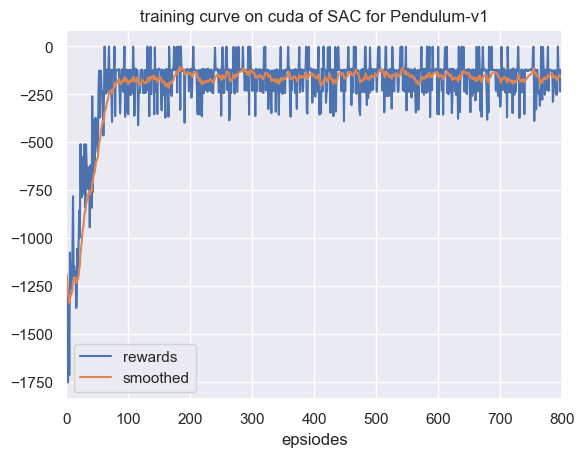

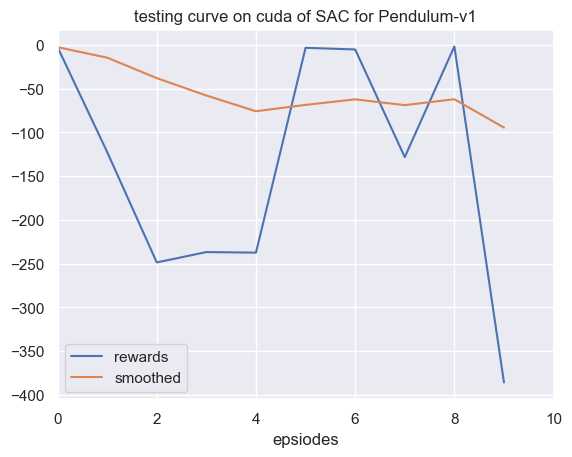

In [8]:
# Ëé∑ÂèñÂèÇÊï∞
cfg = Config() 
# ËÆ≠ÁªÉ
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)
 
plot_rewards(res_dic['rewards'], title=f"training curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")  
# ÊµãËØï
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], title=f"testing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")  # ÁîªÂá∫ÁªìÊûú